In [ ]:
# demo: loads file with all messages (CSTARTTIME, CSENDERENDPOINTID, ymdhm )
# show some charts, anomaly detection with LSTM autoencoders

In [7]:
import dfBasics
import common
import encoder
import pfAdapt
import charts
#import anomaly

In [8]:
import pandas as pd
from pyspark.sql import functions

In [9]:
#pfall = pd.read_parquet('/tmp/msgsenders_0702.parquet', engine='fastparquet')
pfall = pd.read_parquet('/tmp/sla_1580137124017.parquet', engine='pyarrow')

In [15]:
#adddatecolumns(pfall,pfall,'CSTARTTIME')
#pfall.head()
pfall.dtypes

CGLOBALMESSAGEID       int64
CSTARTTIME             int64
CENDTIME               int64
CSTATUS                int64
CSERVICE               int64
CSENDERPROTOCOL        int64
CSENDERENDPOINTID      int64
CINBOUNDSIZE           int64
CRECEIVERPROTOCOL      int64
CRECEIVERENDPOINTID    int64
CSLATAT                int64
CMESSAGETAT2           int64
CSLADELIVERYTIME       int64
year                   int64
month                  int64
day                    int64
hour                   int64
minute                 int64
dtype: object

In [13]:
from datetime import time
import datetime as dt
import calendar
import pytz
de = pytz.timezone('Europe/Berlin')

# long timestamp
def date(x):
    return  dt.datetime.fromtimestamp(float(x) / 1e3, tz=de)


def adddatecolumns(data,pf,column) :
    data['year'] = pf[column].apply(lambda x: date(x).date().year)
    data['month'] = pf[column].apply(lambda x: date(x).date().month)
    data['day'] = pf[column].apply(lambda x: date(x).date().day)
    data['hour'] = pf[column].apply(lambda x: date(x).time().hour)
    data['minute'] = pf[column].apply(lambda x: date(x).time().minute)
    #data['second'] = pf[column].apply(lambda x: x.time().second)
    #data['microsecond'] = pf[column].apply(lambda x: x.time().microsecond)

def converttimestampcolumnn(pf,tsc) :
    pf[tsc] = pf[tsc].apply(lambda x: dt.datetime.fromtimestamp(float(x) / 1e3))

In [11]:
## Setup charts
import pandas as pd
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
print("Setup Complete")

def get_ym_string(a,b) :
    return a + "-" + b
    #return a.join(["-",b]) 

def get_ym(mdcountsall) :
    a = mdcountsall.index.get_level_values(0).astype(str)
    b = mdcountsall.index.get_level_values(1).astype(str)
    return a,b

def get_ymd(mdcountsall) :
    a = mdcountsall.index.get_level_values(0).astype(str)
    b = mdcountsall.index.get_level_values(1).astype(str)
    c = mdcountsall.index.get_level_values(2).astype(str)
    return a,b,c

def get_ymd_string(a,b,c) :
    return a + "-" + b + "-" + c 

def get_ymdh(mdcountsall) :
    a = mdcountsall.index.get_level_values(0).astype(str)
    b = mdcountsall.index.get_level_values(1).astype(str)
    c = mdcountsall.index.get_level_values(2).astype(str)
    d = mdcountsall.index.get_level_values(3).astype(str)
    return a,b,c,d

def get_ymdh_string(a,b,c,d) :
    return a + "-" + b + "-" + c + "-" + d

def createData_ym(pfall,month) :
    if (month > 0) & (month < 13) :
        mdcountsall = pfall[(pfall['month'] == month)].groupby(['year','month'])['year'].count()
    else :
        mdcountsall = pfall.groupby(['year','month'])['year'].count()    
    a,b = get_ym(mdcountsall)
    data2 = pd.DataFrame()
    data2['date'] = get_ym_string(a,b)
    data2['outcome'] = mdcountsall.reset_index(level=0, drop=True).reset_index()['year'].astype(int) 
    return data2

def createData(pfall,month) :
    if (month > 0) & (month < 13) :
        mdcountsall = pfall[(pfall['month'] == month)].groupby(['year','month','day','hour'])['year'].count()
    else :
        mdcountsall = pfall.groupby(['year','month','day','hour'])['year'].count()    
    a,b,c,d = get_ymdh(mdcountsall)
    data2 = pd.DataFrame()
    data2['date'] = get_ymdh_string(a,b,c,d)
    data2['outcome'] =  mdcountsall.reset_index(level=0, drop=True).reset_index()['year'].astype(int)

    #for pivot table
    data2['hours'] =  d.astype(int) 
    data2['days']  =  c.astype(int) 
    return data2

def createData_ymd(pfall,month) :
    if (month > 0) & (month < 13) :
        mdcountsall = pfall[(pfall['month'] == month)].groupby(['year','month','day'])['year'].count()
    else :
        mdcountsall = pfall.groupby(['year','month','day'])['year'].count()    
    a,b,c = get_ymd(mdcountsall)
    data2 = pd.DataFrame()
    data2['date'] = get_ymd_string(a,b,c)
    data2['outcome'] = mdcountsall.reset_index(level=0, drop=True).reset_index()['year'].astype(int) 
    return data2

def label(graph,skip,rot) :
    for ind, label in enumerate(graph.get_xticklabels()):
        if ind % skip == 0:  # every 10th label is kept
            label.set_visible(True)
            label.set_rotation(rot)
        else:
            label.set_visible(False)

def createBarplot(md,fx,fy,fontscale,title="") :
    sns.set(style='whitegrid', palette='muted', font_scale=fontscale)
    plt.figure(figsize=(fx,fy))
    plt.title(title)
    ax = sns.barplot(x=md['date'], y=md['outcome'], data=md)
    plt.setp( ax.xaxis.get_majorticklabels(), rotation=75 )
    plt.tight_layout()
    plt.show()
    return ax

## heatmap
def createHeatmap(piv,title="") :
    plt.figure(figsize=(24,8))
    plt.title(title)
    ax = sns.heatmap(piv, square=True)
    plt.setp( ax.xaxis.get_majorticklabels(), rotation=0 )
    plt.tight_layout()
    plt.show()
    return ax

Setup Complete


# Charts

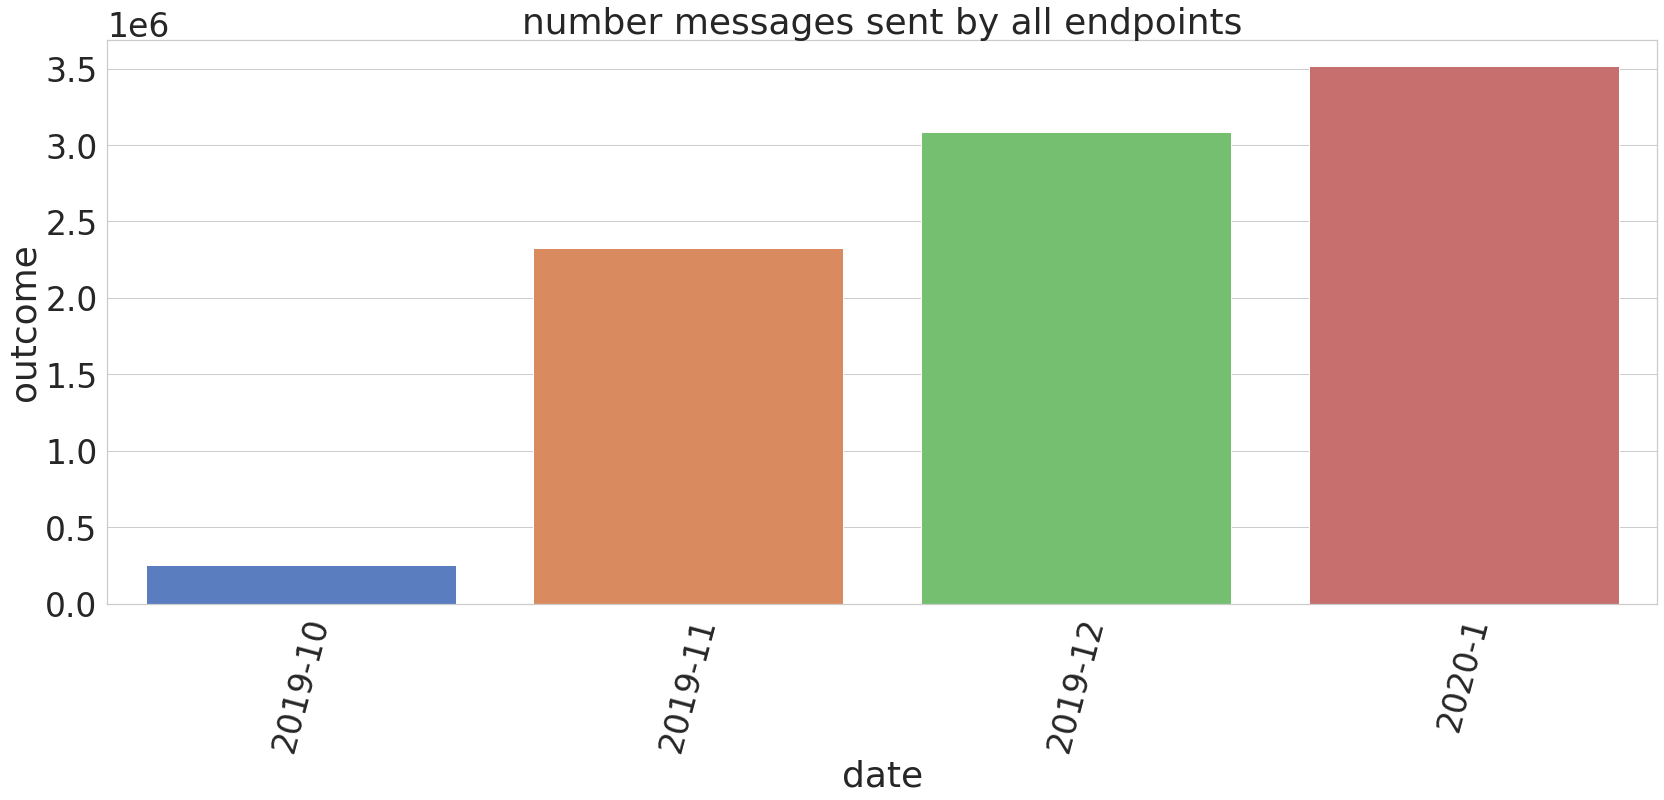

In [16]:
md = createData_ym(pfall,0)
ax=createBarplot(md,24,12,3.0,title="number messages sent by all endpoints")
#label(ax,1000,90)

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

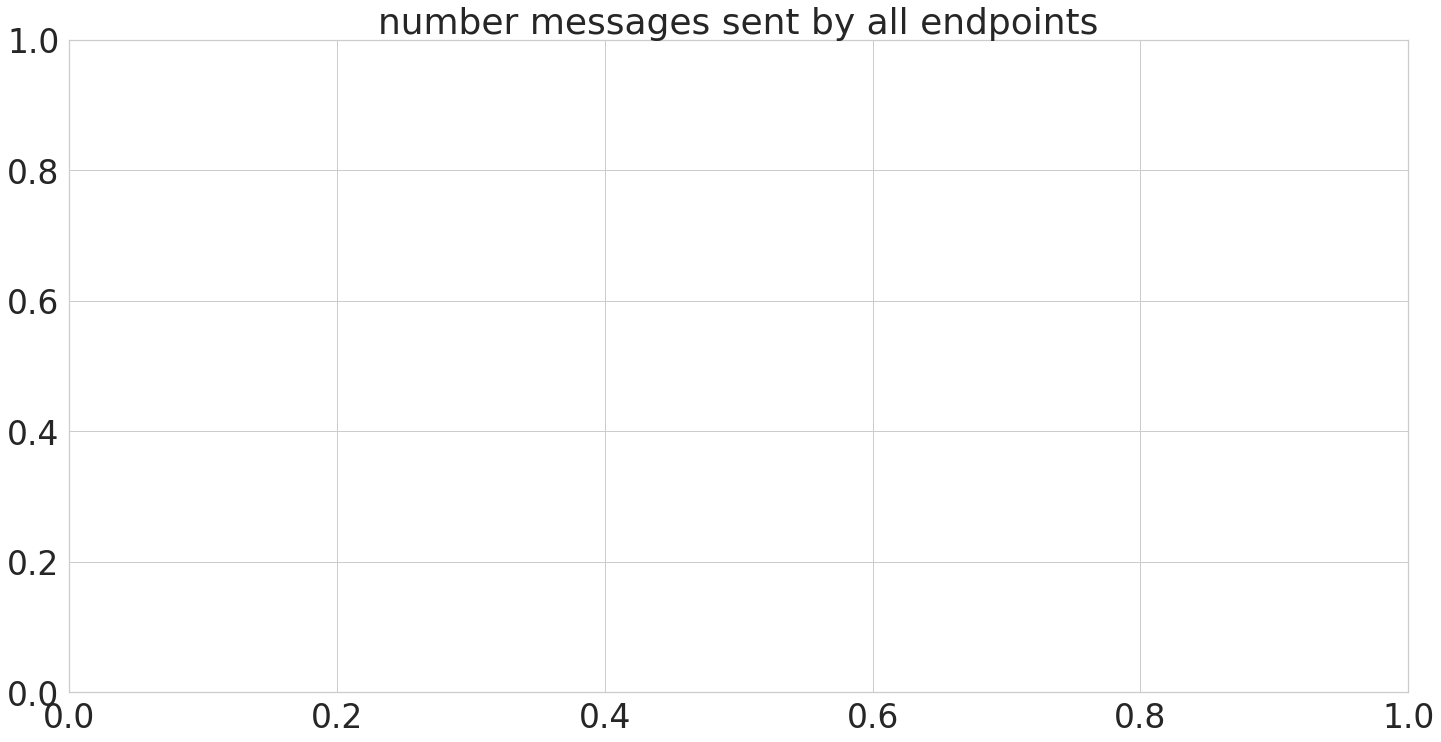

In [17]:
md = createData_ymd(pfall,7)
ax=createBarplot(md,24,12,3.0,title="number messages sent by all endpoints")
label(ax,1000,90)

In [ ]:
def createHeatmapPfall(pfall,sender,month):
    data2 = createData(pfall,month)
    piv = pd.pivot_table(data2, values="outcome",index=["hours"], columns=["days"], fill_value=0)
    #titlestring = "CSENDERENDPOINTID: " + str(topsender.iloc[7]['CSENDERENDPOINTID']) + ": "+ category + " so far = " + str(topsender.iloc[7]['outcome']) + " , month: " + str(month) 
    #titlestring = "CSENDERENDPOINTID: " + str(topsender.iloc[7]['CSENDERENDPOINTID']) + ": "+ category  + " month: " + str(month) 
    titlestring ="number messages 2020-" + str(month) + " sender: " + sender
    sns.set(style='whitegrid', palette='muted', font_scale=1.2)
    createHeatmap(piv, titlestring)
    
createHeatmapPfall(pfall,'all',7)

In [ ]:
createHeatmapPfall(pfall,'all',6)

# Top senders

In [ ]:
#pd.unique(mdcountsall[1].index.get_level_values(0))
def getTopSenders(TOP):
    result = pfall.groupby(['CSENDERENDPOINTID']).count()
    data2 = pd.DataFrame()
    data2['date'] = result.index.get_level_values(0).astype(str)
    data2['outcome'] =  result['CSTARTTIME'].astype(int)
    topsender =  data2[data2['outcome'] > TOP].sort_values('outcome', ascending=False).reset_index()
    topsender['outcome'] = topsender['outcome'].astype(int)
    topsender.columns = ['index', 'CSENDERENDPOINTID', 'count']
    return topsender

topsender = getTopSenders(500000)
topsender

In [ ]:
numbersenders = len(pfall['CSENDERENDPOINTID'].unique())
print('sending endpoints: '  + str(numbersenders))

In [ ]:
sender = topsender.iloc[0]['index']
pfall1 = pfall[pfall['CSENDERENDPOINTID'] == sender].sort_values('CSTARTTIME').reset_index() 

def get_datestr(row):
    return str(row.day) + "." + str(row.month) + "." + str(row.year) 

In [ ]:
createHeatmapPfall(pfall1,str(sender),5)

# Time Series Anomaly Detection with LSTM Autoencoders (selected sender)

In [ ]:
anomaly.init_sns()

In [ ]:
model,scaler,train,test,X_test,X_train,X_train_pred,train_mae_loss = anomaly.initAndTrain(pfall1,0.94)

In [ ]:
sns.distplot(train_mae_loss, bins=50, kde=True);

In [ ]:
test_score_df = anomaly.testScoreDF(model, 1.9,X_test,test)
anomalies     = test_score_df[test_score_df.anomaly == True]

In [ ]:
plt.plot(test_score_df.index, test_score_df.loss, label='loss')
plt.plot(test_score_df.index, test_score_df.threshold, label='threshold')
plt.xticks(rotation=25)
plt.legend();

In [ ]:
titlestring ="endpoint (sending) : " + str(sender) + " ( trained: " +  train.index[0] + " -- " + train.index[len(train.index)-1] + " )"
anomaly.plot_test(test,scaler,anomalies,titlestring)